In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def feature_map(points, degree=4):
    points = np.array(points)
    x, y = points[:, 0], points[:, 1]

    features = []
    for i in range(degree + 1):
        for j in range(degree + 1 - i):
            features.append((x ** i) * (y ** j))

    return np.column_stack(features)

In [3]:
class LogisticRegression:

    def __init__(self) -> None:
        self.weights: np.ndarray | None = None
        self.bias: float | None = None

    def __sigmoid(self, z: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-z))

    def predict_probability(self, X: np.ndarray) -> np.ndarray:
        return self.__sigmoid(X @ self.weights + self.bias)

    def predict(self, X: np.ndarray) -> np.ndarray:
        probs = self.predict_probability(X)
        return (probs >= 0.5).astype(int)

    def __loss(self, X: np.ndarray, y: np.ndarray, lambda_reg: float = 0):
        n = X.shape[0]

        y_pred = self.predict_probability(X)

        loss = -(1 / n) * np.sum(
            y * np.log(y_pred + 1e-9) +
            (1 - y) * np.log(1 - y_pred + 1e-9)
        )

        dw = (1 / n) * X.T @ (y_pred - y)
        db = (1 / n) * np.sum(y_pred - y)

        # L2 Regularization
        loss += (lambda_reg / (2 * n)) * np.sum(self.weights ** 2)
        dw += (lambda_reg / n) * self.weights

        return loss, dw, db

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        epochs: int = 500,
        learning_rate: float = 0.01,
        threshold: float = 0.0001,
        lambda_reg: float = 1
    ) -> None:

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        prev_loss = float("inf")

        for _ in range(epochs):
            loss, dw, db = self.__loss(X, y, lambda_reg)

            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

            if abs(prev_loss - loss) < threshold:
                break

            prev_loss = loss

In [4]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Dunggam/AutoDamage-Vision/main/Week%201/Logistic-Regression/logistic_data.csv"
)

data = df.to_numpy()
X = data[:, :2]
y = data[:, 2]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
def z_score(X: np.ndarray) -> tuple:
    X = X.astype(float)
    x_mean = np.mean(X, axis=0)
    x_std = np.std(X, axis=0)
    x = (X - x_mean) / x_std
    return x, x_mean, x_std

In [7]:
X_train, x_mean, x_std = z_score(X_train)
X_test = (X_test - x_mean) / x_std

X_train = feature_map(X_train)
X_test = feature_map(X_test)

In [8]:
def plot_decision_boundary(X_original, y, model, resolution=500):
    x_min, x_max = X_original[:, 0].min() - 1, X_original[:, 0].max() + 1
    y_min, y_max = X_original[:, 1].min() - 1, X_original[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )

    grid_original = np.c_[xx.ravel(), yy.ravel()]
    grid_original = (grid_original - x_mean) / x_std
    grid_expanded = feature_map(grid_original)

    Z = model.predict(grid_expanded)
    Z = Z.reshape(xx.shape)

    true_pts = X_original[y == 1]
    false_pts = X_original[y == 0]

    plt.scatter(true_pts[:, 0], true_pts[:, 1], c="blue", label="True", marker="o")
    plt.scatter(false_pts[:, 0], false_pts[:, 1], c="red", label="False", marker="x")

    plt.contour(xx, yy, Z, levels=[0.5], colors="black")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary and Data Points")
    plt.legend()
    plt.show()

In [9]:
model = LogisticRegression()

model.fit(
    X_train,
    y_train,
    epochs=500,
    learning_rate=0.01,
    threshold=0.0001,
    lambda_reg=1
)

y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100

print(f"Your model has an accuracy of {accuracy:.2f}%")

Your model has an accuracy of 92.50%


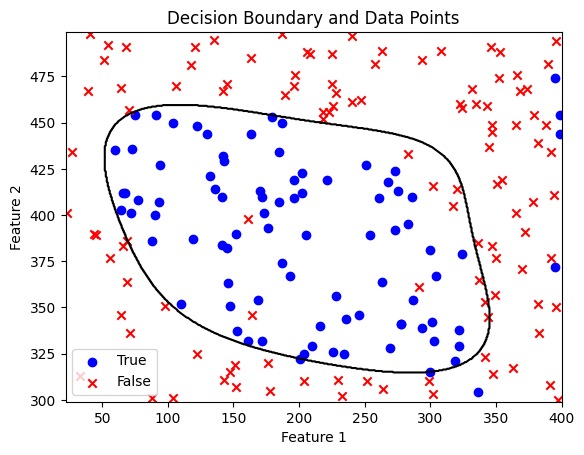

In [10]:
plot_decision_boundary(X, y, model)